In [1]:
import tldextract
import pandas as pd
import json
import os
from tqdm import tqdm
from ftlangdetect import detect
from source_credibility import SourceCredibility

# Blacklists
BLACKLIST_DOMAINS = {
    "jstor.org",
    "facebook.com",
    "twitter.com",
    "x.com",
    "reddit.com",
    "linkedin.com",
    "threads.net",
    "quora.com",
    "tiktok.com",
    "instagram.com",
    "discord.com",
    "youtube.com",
    "spotify.com",
    "huggingface.co",
    "politifact.com",
    "snopes.com",
    "factcheck.org",
    "shutterstock.com",
    "naturepl.com",
    "example.com",
    "pinterest.com",
    "flickr.com",
    "twitch.tv",
    "verifythis.com",
    "telegram.org",
    "factcheck.africa",
}

BLACKLIST_FILES = [
    "/glove.",
    "ftp://ftp.cs.princeton.edu/pub/cs226/autocomplete/words-333333.txt",
    "https://web.mit.edu/adamrose/Public/googlelist",
]

def get_domain_name(url):
    if '://' not in url:
        url = 'http://' + url
    extracted = tldextract.extract(url)
    return f"{extracted.domain}.{extracted.suffix}"

def should_filter_link(link):
    domain = get_domain_name(link)
    if domain in BLACKLIST_DOMAINS:
        return True
    if any(b_file in link for b_file in BLACKLIST_FILES):
        print("Blacklisted file: ", link)
        return True
    if link.endswith((".txt")):
        print("Blacklisted file type: ", link)
        return True
    return False

with open("../data/search_results.json", "r") as f:
    search_results = json.load(f)

credibility_checker = SourceCredibility()

if os.path.exists("../data/domain_credibility.json"):
    with open("../data/domain_credibility.json", "r") as f:
        domain_credibility = json.load(f)
else:
    domain_credibility = {}
print(len(domain_credibility))

11375


In [2]:
# Find all unique domains 
domains = set()
links = set()
for claim in search_results.keys():
    # Exclude claims that are not in english
    claim_filtered = claim.replace("\n", " ")
    if detect(text=claim_filtered, low_memory=False)["lang"] != "en":
        continue

    for query in search_results[claim].keys():
        for _, results in search_results[claim][query].items():
            for result_object in results:
                url = result_object["link"]
                if should_filter_link(url):
                    continue
                domain_with_port = credibility_checker.extract_domain(url)
                domain = domain_with_port.split(':')[0]
                domains.add(domain)
                links.add(url)

print(len(domains), len(links))

Blacklisted file type:  https://ga.video.cdn.pbs.org/captions/your-vote-kuat/72887b96-4f04-40fe-a5a7-0d3c63523a6a/captions/2dDQrK_caption_en.txt
Blacklisted file:  https://worksheets.codalab.org/rest/bundles/0xadf98bb30a99476ab56ebff3e462d4fa/contents/blob/glove.6B.100d.txt-vocab.txt
Blacklisted file:  https://web.mit.edu/adamrose/Public/googlelist
Blacklisted file type:  https://downloads.cs.stanford.edu/nlp/data/jiwei/data/vocab_wiki.txt
Blacklisted file type:  https://web.stanford.edu/class/cs124/nyt_200811.txt
Blacklisted file type:  https://www.mynavyhr.navy.mil/Portals/55/Messages/NAVADMIN/NAV2022/NAV22005.txt
Blacklisted file type:  https://www.eecis.udel.edu/~lliao/cis320f05/dictionary.txt
11375 51715


In [ ]:
# Cache the results for each domain 
for domain in tqdm(domains):
    if domain in domain_credibility:
        continue
    ssl_status = credibility_checker.get_ssl_status(domain)
    domain_age = credibility_checker.get_domain_age(domain)
    page_rank = credibility_checker.get_open_page_rank(domain)
    tld = credibility_checker.get_tld_score(domain)
    match, bias_rating, factual_rating, credibility_rating = credibility_checker.get_media_bias(domain)

    domain_credibility[domain] = {
        "ssl_status": ssl_status,
        "domain_age": domain_age,
        "page_rank": page_rank,
        "tld_score": tld,
        "matching_domain": match,
        "bias_rating": bias_rating,
        "factual_rating": factual_rating,
        "credibility_rating": credibility_rating
    }

# Save to a json file
with open("data/domain_credibility.json", "w") as f:
    json.dump(domain_credibility, f, indent=4)

In [4]:
from concurrent.futures import ThreadPoolExecutor

def process_domain_info(domain, credibility_checker):
    return {
            'ssl_status': credibility_checker.get_ssl_status(domain),
            'domain_age': credibility_checker.get_domain_age(domain),
            'page_rank': credibility_checker.get_open_page_rank(domain)
        }

# Cache the results for each domain 
with ThreadPoolExecutor(max_workers=10) as executor:
    future_to_domain = {
        executor.submit(process_domain_info, domain, credibility_checker): domain 
        for domain in domains
    }
    
    for future in tqdm(future_to_domain):
        domain = future_to_domain[future]
        if domain in domain_credibility:
            continue
        try:
            result = future.result()
            tld = credibility_checker.get_tld_score(domain)
            match, bias_rating, factual_rating, credibility_rating = credibility_checker.get_media_bias(domain)
            
            domain_credibility[domain] = {
                **result,
                "tld_score": tld,
                "matching_domain": match,
                "bias_rating": bias_rating,
                "factual_rating": factual_rating,
                "credibility_rating": credibility_rating
            }
        except Exception as e:
            print(f"Error processing results for {domain}: {str(e)}")

# Save to a json file
with open("data/domain_credibility.json", "w") as f:
    json.dump(domain_credibility, f, indent=4)

  0%|          | 0/11375 [00:00<?, ?it/s]ERROR:root:Error getting SSL status for jospi.org: [Errno 61] Connection refused
ERROR:root:Error getting domain age for voteputnamflorida.gov after 3 attempts: [Errno 54] Connection reset by peer
ERROR:root:Error getting SSL status for wwno.org: [Errno 61] Connection refused
  0%|          | 1/11375 [00:03<11:13:57,  3.56s/it]ERROR:root:Error getting SSL status for mad.uscourts.gov: [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: self-signed certificate (_ssl.c:1000)
ERROR:root:Error getting SSL status for danehousing.danecounty.gov: timed out
ERROR:root:Error getting SSL status for law.cuny.edu: [Errno 8] nodename nor servname provided, or not known
ERROR:root:Error getting SSL status for water.utah.gov: [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: unable to get local issuer certificate (_ssl.c:1000)
ERROR:root:Error getting SSL status for wild.house.gov: [Errno 8] nodename nor servname provided, or not known
  1%|  

In [6]:
import matplotlib.pyplot as plt

# Do an aggregation of the scores per claim
save_path = "../data/claim_credibility.json"
if os.path.exists(save_path):
    with open(save_path, "r") as f:
        claim_credibility = json.load(f)
else:
    claim_credibility = {}


if os.path.exists("../data/domain_credibility.json"):
    with open("../data/domain_credibility.json", "r") as f:
        domain_credibility = json.load(f)
else:
    domain_credibility = {}

In [9]:
unique_domains = set()
for claim in tqdm(search_results.keys()):
    # Exclude claims that are not in english
    claim_filtered = claim.replace("\n", " ")
    if detect(text=claim_filtered, low_memory=False)["lang"] != "en":
        continue

    credibility_rating = []
    factual_rating = []
    bias_rating = []
    domain_age = []
    tld_score = []
    page_rank = []
    for query in search_results[claim].keys():
        for _, results in search_results[claim][query].items():
            for result_object in results:
                url = result_object["link"]
                if should_filter_link(url):
                    continue
                domain_with_port = credibility_checker.extract_domain(url)
                domain = domain_with_port.split(':')[0]
                val = domain_credibility[domain]
                credibility_rating.append(val["credibility_rating"])
                factual_rating.append(val["factual_rating"])
                bias_rating.append(val["bias_rating"])
                domain_age.append(val["domain_age"])
                tld_score.append(val["tld_score"])
                page_rank.append(val["page_rank"])

    # Apply mapping
    credibility_scores = [credibility_checker.credibility_scores_map.get(x) for x in credibility_rating]
    factual_scores = [credibility_checker.factual_ratings_map.get(x) for x in factual_rating]
    bias_scores = [credibility_checker.bias_scores_map.get(x) for x in bias_rating]

    # Calculate the average
    claim_credibility[claim] = {
        "domain_age": sum(filter(None, domain_age)) / len(list(filter(None, domain_age))) if any(domain_age) else None,
        "tld_score": sum(filter(None, tld_score)) / len(list(filter(None, tld_score))) if any(tld_score) else None,
        "page_rank": sum(filter(None, page_rank)) / len(list(filter(None, page_rank))) if any(page_rank) else None,
        "bias_rating_score": sum(filter(None, bias_scores)) / len(list(filter(None, bias_scores))) if any(bias_scores) else None,
        "factual_rating_score": sum(filter(None, factual_scores)) / len(list(filter(None, factual_scores))) if any(factual_scores) else None,
        "credibility_rating_score": sum(filter(None, credibility_scores)) / len(list(filter(None, credibility_scores))) if any(credibility_scores) else None
    }

with open("../data/claim_credibility.json", "w") as f:
    json.dump(claim_credibility, f, indent=4)

 34%|███▍      | 908/2684 [00:00<00:00, 4633.01it/s]

Blacklisted file type:  https://ga.video.cdn.pbs.org/captions/your-vote-kuat/72887b96-4f04-40fe-a5a7-0d3c63523a6a/captions/2dDQrK_caption_en.txt
Blacklisted file:  https://worksheets.codalab.org/rest/bundles/0xadf98bb30a99476ab56ebff3e462d4fa/contents/blob/glove.6B.100d.txt-vocab.txt
Blacklisted file:  https://web.mit.edu/adamrose/Public/googlelist
Blacklisted file type:  https://downloads.cs.stanford.edu/nlp/data/jiwei/data/vocab_wiki.txt
Blacklisted file type:  https://web.stanford.edu/class/cs124/nyt_200811.txt
Blacklisted file type:  https://www.mynavyhr.navy.mil/Portals/55/Messages/NAVADMIN/NAV2022/NAV22005.txt


100%|██████████| 2684/2684 [00:00<00:00, 4864.63it/s]

Blacklisted file type:  https://www.eecis.udel.edu/~lliao/cis320f05/dictionary.txt


In [10]:
credibility_scores = []
domain_ages = []
bias_scores = []
tld_scores = []
page_ranks = []
factual_scores = []

for claim in claim_credibility.keys():
    credibility_scores.append(claim_credibility[claim]["credibility_rating_score"])
    domain_ages.append(claim_credibility[claim]["domain_age"])
    bias_scores.append(claim_credibility[claim]["bias_rating_score"])
    tld_scores.append(claim_credibility[claim]["tld_score"])
    page_ranks.append(claim_credibility[claim]["page_rank"])
    factual_scores.append(claim_credibility[claim]["factual_rating_score"])

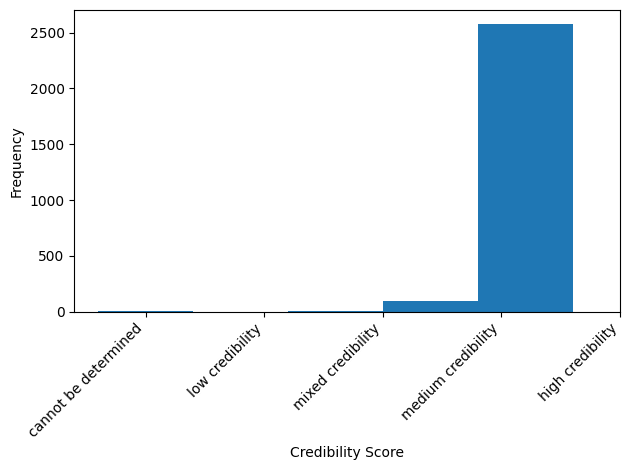

In [11]:
# Replace None with 0
credibility_scores = [x if x is not None else 0 for x in credibility_scores]

# Create labels mapping
credibility_labels = {
    0: 'cannot be determined',
    1: 'low credibility', 
    2: 'mixed credibility',
    3: 'medium credibility',
    4: 'high credibility'
}

plt.xlabel("Credibility Score")
plt.ylabel("Frequency")
plt.hist(credibility_scores, bins=len(credibility_labels), align='left')

# Add x-axis labels
plt.xticks(range(len(credibility_labels)), list(credibility_labels.values()), rotation=45, ha='right')

plt.tight_layout()
plt.show()

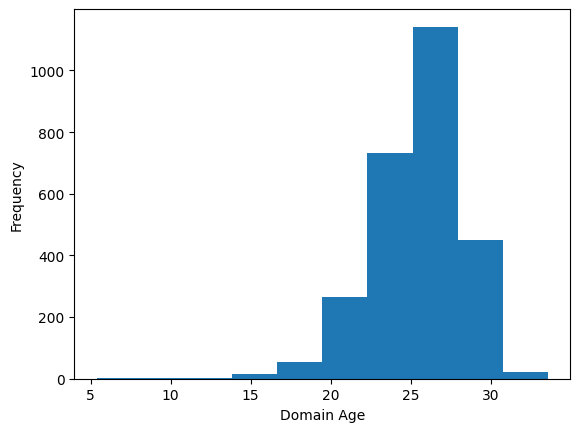

In [12]:
# Remove the None values
domain_ages = [x for x in domain_ages if x is not None]

plt.xlabel("Domain Age")
plt.ylabel("Frequency")
plt.hist(domain_ages)
plt.show()

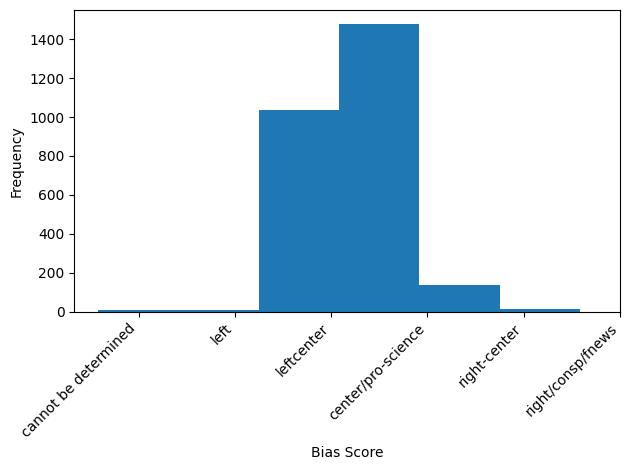

In [13]:
# Replace bias score with 0 the None values
bias_scores = [x if x is not None else 0 for x in bias_scores]

# Create labels mapping
bias_labels = {
    0: "cannot be determined",
    1: "left",
    2: "leftcenter",
    3: "center/pro-science",
    4: "right-center",
    5: "right/consp/fnews",
}

plt.xlabel("Bias Score")
plt.ylabel("Frequency")
plt.hist(bias_scores, bins=len(bias_labels), align='left')

# Add x-axis labels
plt.xticks(range(len(bias_labels)), list(bias_labels.values()), rotation=45, ha='right')

plt.tight_layout()
plt.show()

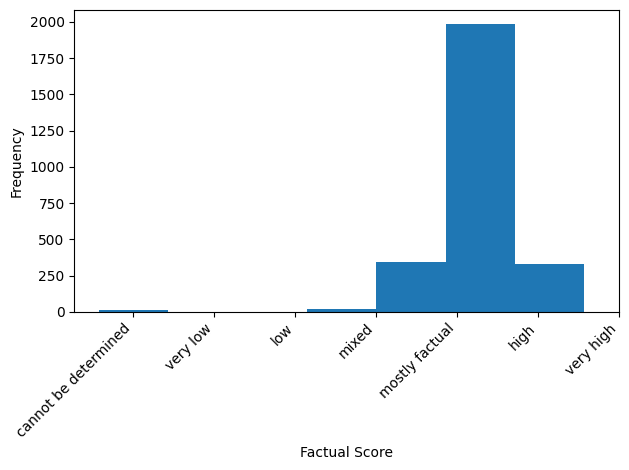

In [14]:
# Factual scores
factual_scores = [x if x is not None else 0 for x in factual_scores]

factual_labels = {
    0: "cannot be determined",
    1: "very low",
    2: "low",
    3: "mixed",
    4: "mostly factual",
    5: "high",
    6: "very high",
}

plt.xlabel("Factual Score")
plt.ylabel("Frequency")
plt.hist(factual_scores, bins=len(factual_labels), align='left')

# Add x-axis labels
plt.xticks(range(len(factual_labels)), list(factual_labels.values()), rotation=45, ha='right')

plt.tight_layout()
plt.show()

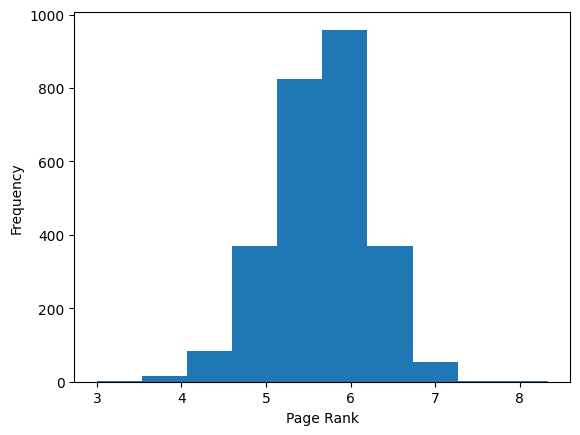

In [15]:
# Remove the None values
page_ranks = [x for x in page_ranks if x is not None]

plt.xlabel("Page Rank")
plt.ylabel("Frequency")
plt.hist(page_ranks)
plt.show()

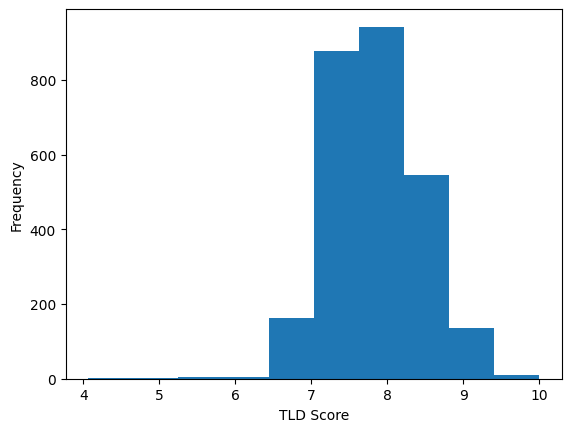

In [16]:
# tld scores
tld_scores = [x for x in tld_scores if x is not None]

plt.xlabel("TLD Score")
plt.ylabel("Frequency")
plt.hist(tld_scores)
plt.show()